## Cookie Cats и цель проекта

**Cookie Cats** — чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедини три», в которой игрок должен соединять плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

<img src="maxresdefault.jpg" width="500" height="300">

По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать нетривиальное количество времени или совершать покупки в приложении для продвижения. Помимо стимулирования покупок в приложении, эти ворота служат важной цели: дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия игрока от игры.

<img src="cc_gates.png" width="500" height="300">

**Но где должны быть расположены ворота?** Изначально первые ворота были размещены на уровне 30, но в этом эксперименте мы собираемся проанализировать AB-тест, в котором мы переместили первые ворота в Cookie Cats с уровня 30 на уровень 40. В частности, мы рассмотрим влияние на удержание игроков. Но прежде чем мы доберемся до этого, ключевым шагом перед проведением любого анализа является понимание данных.

## Набор данных и переменные

У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. 

* userid — уникальный номер, идентифицирующий каждого игрока.

* version - попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или группу с перенесенными воротами (gate_40 - ворота 40 уровня).

* sum_gamerounds — количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.

* retention_1 - вернулся ли игрок и играл через 1 день после установки?

* retention_7 -  вернулся ли игрок и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему или ей случайным образом присваивались gate_30 или gate_40.


In [31]:
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
from statsmodels.stats.power import TTestIndPower
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno


from matplotlib import pyplot as plt

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [32]:
df = pd.read_csv('result_cookie_cats.csv')
df.sample(10)

,userid,version,sum_gamerounds,retention_1,retention_7
34540,3826259,gate_30,9,0,0
1162,128450,gate_40,2,0,0
75042,8311820,gate_40,461,1,1
5337,593811,gate_40,1,0,0
71161,7888922,gate_30,171,1,0
49745,5517167,gate_40,46,0,1
44229,4899334,gate_30,47,0,1
7662,846571,gate_30,59,1,0
87884,9739442,gate_30,145,0,1
46716,5179679,gate_30,2,0,0


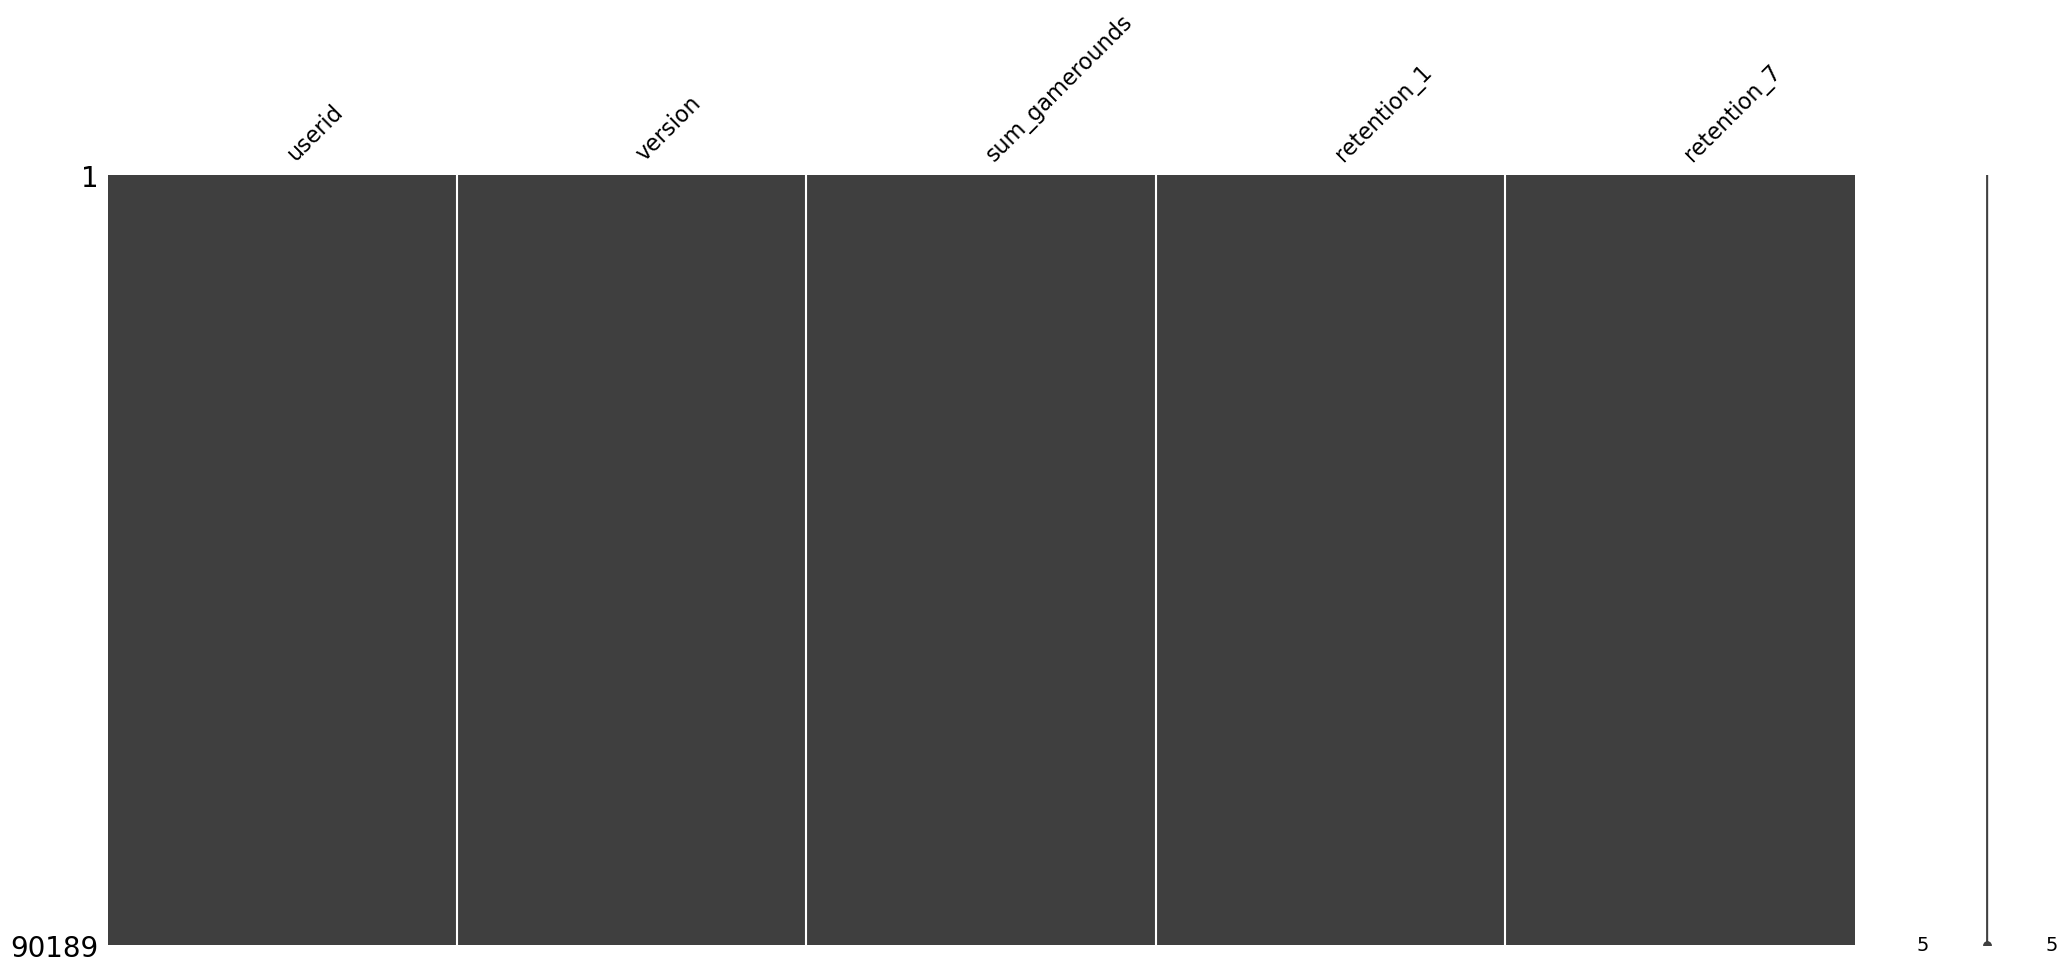

In [33]:
msno.matrix(df);

In [34]:
df.userid.nunique() # количество уникальных игроков

90189

In [35]:
df_group = df.groupby(['version'], as_index=False)[['userid']].nunique()

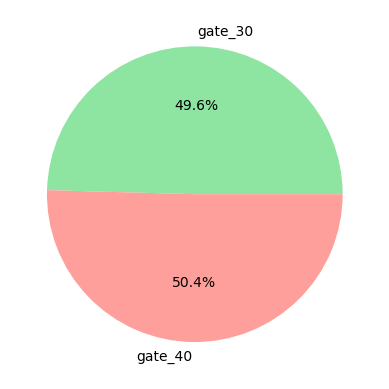

,version,userid
0,gate_30,44700
1,gate_40,45489


In [36]:
color = sns.color_palette('pastel')[2:4]
plt.pie(df_group.userid, labels=df_group.version, colors=color, autopct='%.1f%%')
plt.show();
df_group

**В данных нет пропущенных значений и дубликатов. В каждой группе примерно равное количество игроков**

Посмотрим, как вели себя игроки после установки игры:

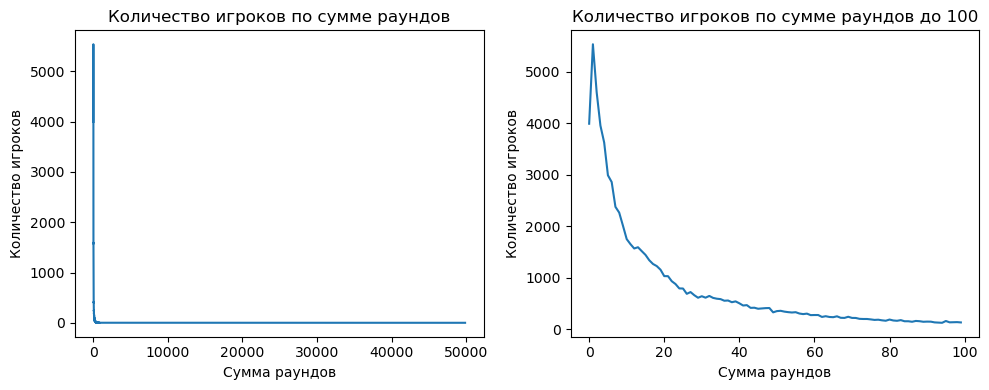

In [37]:
behavior_users = df.groupby(['sum_gamerounds'])['userid'].count()

fig, (ax_plot, ay_plot) = plt.subplots(1, 2, figsize=(10, 4))

ax_plot.set_title('Количество игроков по сумме раундов')
behavior_users.plot(ax=ax_plot)
ax_plot.set_xlabel('Сумма раундов')
ax_plot.set_ylabel('Количество игроков')

ay_plot.set_title('Количество игроков по сумме раундов до 100')
behavior_users.head(100).plot(ax=ay_plot)
ay_plot.set_xlabel('Сумма раундов')
ay_plot.set_ylabel('Количество игроков')

plt.tight_layout()
plt.show();

**Из графика очевидно, что много игроков установили игру, но так и не играли. Рассчитаем их количество:**

In [38]:
df[df.sum_gamerounds == 0]['userid'].count()

3994

Рассмотрим метрику по сумме раундов более детально (описательную статистику и графики boxplot)

In [39]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

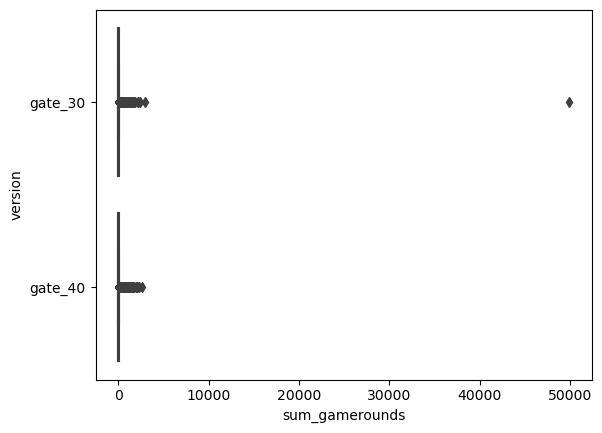

In [40]:
sns.boxplot(data=df, x='sum_gamerounds', y='version');

В группе gate_30 есть существенный выброс.

In [41]:
df[df.sum_gamerounds == max(df.sum_gamerounds)]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1


Предположительно в данных есть ошибка, так как у нас всего один игрок, который сыграл такое количесво раундов в течении 7 дней. Исключим из данных этого пользователя.

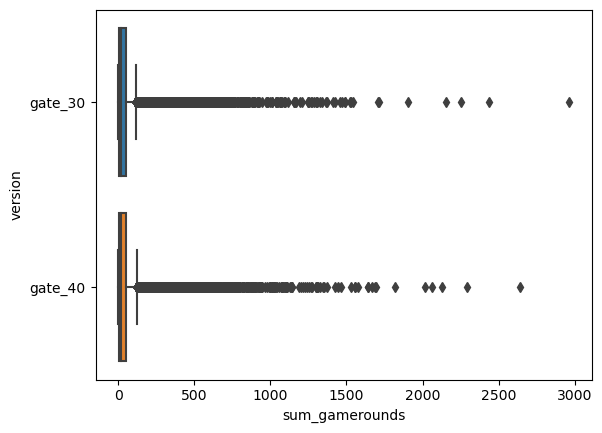

In [42]:
df_clean = df.loc[df.sum_gamerounds != max(df.sum_gamerounds)]
sns.boxplot(data=df_clean, x='sum_gamerounds', y='version');

Выбросов по прежнему очень много, из описательной статистики известно, что 75% пользователей сыграли не более 51 раунда. Исключим из данных часть выбросов.

In [43]:
df_clean = df_clean[df_clean.sum_gamerounds < df_clean.sum_gamerounds.quantile(0.975)]
df_clean.groupby(['version'], as_index=False).agg({'sum_gamerounds': 'sum', 'userid': 'count'})

,version,sum_gamerounds,userid
0,gate_30,1705015,43568
1,gate_40,1732906,44359


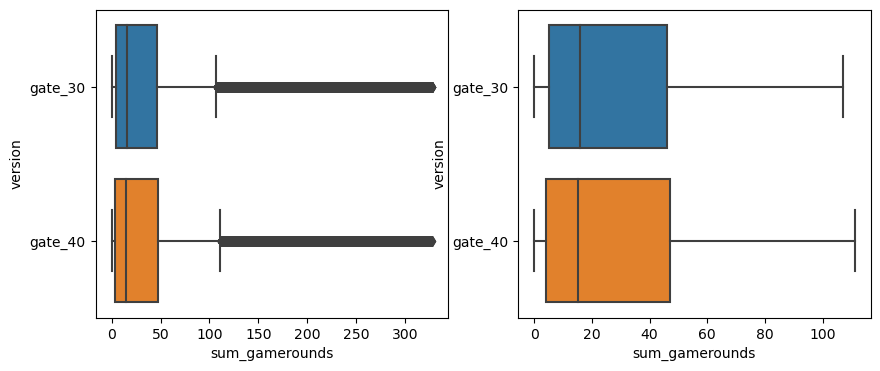

In [44]:
fig, (ax_boxplot, ay_boxplot) = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df_clean, x='sum_gamerounds', y='version', ax=ax_boxplot)
sns.boxplot(data=df_clean, x='sum_gamerounds', y='version', showfliers=False, ax=ay_boxplot)
plt.show();

In [45]:
print('Средние значения по сумме раундов в группах gate_30 и gate_40 соответственно:')
print(f"{df_clean[df_clean.version=='gate_30']['sum_gamerounds'].mean():.4f}\n" 
      f"{df_clean[df_clean.version=='gate_40']['sum_gamerounds'].mean():.4f}")

Средние значения по сумме раундов в группах gate_30 и gate_40 соответственно:
39.1346
39.0655


In [46]:
print('Медианы сумм раундов в группах gate_30 и gate_40 соответственно:')
print(f"{df_clean[df_clean.version=='gate_30']['sum_gamerounds'].median():.4f}\n" 
      f"{df_clean[df_clean.version=='gate_40']['sum_gamerounds'].median():.4f}")

Медианы сумм раундов в группах gate_30 и gate_40 соответственно:
16.0000
15.0000


Из графиков и описательной статистики очевидно, что разница в данной метрике незначительна.<br>Рассмотрим распределения и рассчитаем статистические критерии для подтверждения отсутсвия различий.

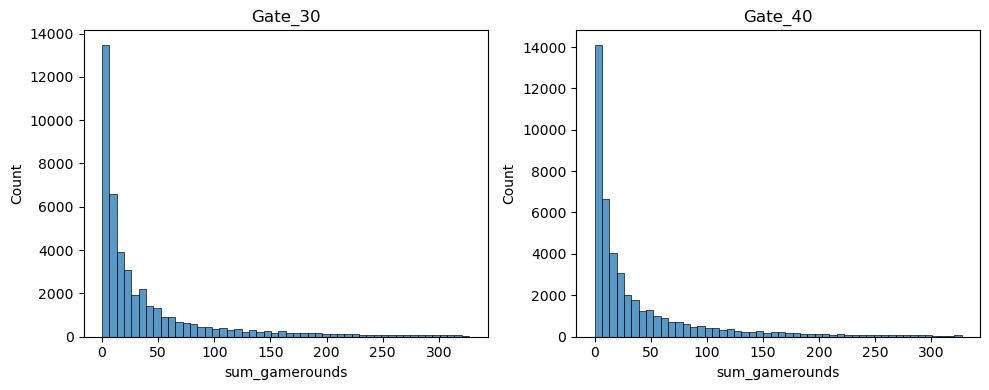

In [47]:
fig, (ax_histplot, ay_histplot) = plt.subplots(1, 2, figsize=(10, 4))

ax_histplot.set_title('Gate_30')
sns.histplot(df_clean.sum_gamerounds[df_clean.version=='gate_30'], bins=50, ax=ax_histplot);


ay_histplot.set_title('Gate_40')
sns.histplot(df_clean.sum_gamerounds[df_clean.version=='gate_40'], bins=50, ax=ay_histplot);

plt.tight_layout()
plt.show();

Распределения в группах не является нормальными. Так как у нас 2 независимые выборки и распределение ненормальное, то для проверки статистической значимости применим критерий Манна-Уитни, но также рассчитаем и критерий Стьюдента, так как у нас достаточно много наблюдений.

In [48]:
mannwhitneyu(df_clean[df.version == 'gate_30']['sum_gamerounds'].values, 
             df_clean[df.version == 'gate_40']['sum_gamerounds'].values)

MannwhitneyuResult(statistic=973479144.5, pvalue=0.056885991038433344)

In [49]:
ttest_ind(df_clean[df.version == 'gate_30']['sum_gamerounds'].values, 
             df_clean[df.version == 'gate_40']['sum_gamerounds'].values, equal_var = False)

Ttest_indResult(statistic=0.17892458615040838, pvalue=0.8579973297392993)

В результате расчета по обоим критериям pvalue > 0.05 => нет статистически значимых различий. 

Расчитаем мощность нашего теста.

In [50]:
alpha = 0.05

C_mean = df[df.version == 'gate_30']['sum_gamerounds'].values.mean()
T_mean = df[df.version == 'gate_40']['sum_gamerounds'].values.mean()

C_std = df[df.version == 'gate_30']['sum_gamerounds'].values.std()
T_std = df[df.version == 'gate_40']['sum_gamerounds'].values.std()

S = np.sqrt((T_std**2 + C_std **2)/ 2)
effect_size =float((T_mean-C_mean)/ S)

n = df[df.version == 'gate_30']['userid'].count()

analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=None, nobs1=n, ratio=1.0, alpha=alpha)
result

0.14327904497194127

Мощность теста составляет 14%, что является критически низким для принятия верного решения, так как с таким значением мощности мы имеем очень низкую вероятность обнаружить статистически значимые различия. Для увеличения мощности необходимо увеличить размер выборки:

In [51]:
power = 0.8
N = analysis.solve_power(effect_size=effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
round(N), round(N/n)

(448581, 10)

Таким образом, для A/B-теста по количеству сыгранных раундов необходимо увеличить размер выборки для группы в 10 раз и повторить эксперимент, в том случае если сумма раундов является важным показателем, я предполагаю, что показатели удержания - основные метрики в данном тесте.

### Посмотрим какие доли игроков у нас возвращаются в игру через 1 и 7 дней после установки:

In [52]:
ret_1_mean = df.retention_1.mean()
ret_7_mean = df.retention_7.mean()

print(f'{ret_1_mean=:.3f}, {ret_7_mean=:.3f}')

ret_1_mean=0.445, ret_7_mean=0.186


Спустя 1 день после установки возвращается почти 45% игроков, спустя 7 дней почти 19% игроков.

Посмотрим какие у нас различия в группах:

In [53]:
share_retention = df.groupby(['version']).agg({'userid': 'count', 'retention_1': 'mean', 
                                                   'retention_7': 'mean', 'sum_gamerounds': 'sum'})
share_retention

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


В группах есть небольшие различия, в группе gate_40 доля игроков незначительно, но меньше, чем в группе gate_30. 

Посмотрим на статическую значимость этих различий:

In [54]:
group_30_ret_1 = df[df.version == 'gate_30']['retention_1'].values
group_40_ret_1 = df[df.version == 'gate_40']['retention_1'].values

group_30_ret_7 = df[df.version == 'gate_30']['retention_7'].values
group_40_ret_7 = df[df.version == 'gate_40']['retention_7'].values

In [55]:
result_1 = bs.bootstrap_ab(group_30_ret_1, group_40_ret_1, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, alpha=0.05, num_iterations=1000)

print(f'Доверительный интервал retention_1: {round(result_1.lower_bound, 4)} - {round(result_1.upper_bound, 4)}')

result_7 = bs.bootstrap_ab(group_30_ret_7, group_40_ret_7, stat_func=bs_stats.mean,
                           compare_func=bs_compare.difference, alpha=0.05, num_iterations=1000)

print(f'Доверительный интервал retention_7: {round(result_7.lower_bound, 4)} - {round(result_7.upper_bound, 4)}')

Доверительный интервал retention_1: -0.0005 - 0.0128
Доверительный интервал retention_7: 0.0028 - 0.0134


Из расчета мы видим, что доверительный интервал проходит через ноль для 1-дневного удержания, что говорит о том, что нет статистически значимых различий, в 7-дневном удержании доверетильный интервал не проходит через ноль, таким образом есть статитстически значимые различия. 

Рассмотрим также критерий Хи-квадрат для расчета статистической значимости:

In [56]:
frequency_retention = df.groupby(['version']).agg({'userid': 'count', 'retention_1': 'sum', 
                                                   'retention_7': 'sum', 'sum_gamerounds': 'sum'})
frequency_retention

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,20034,8502,2344795
gate_40,45489,20119,8279,2333530


In [57]:
m_A_1, m_B_1 = frequency_retention.retention_1
m_A_7, m_B_7 = frequency_retention.retention_7

n_A, n_B = frequency_retention.userid

stat_1, p_value_1, _, _ = chi2_contingency([[m_A_1, n_A-m_A_1], [m_B_1, n_B - m_B_1]], correction=False)
stat_7, p_value_7, _, _ = chi2_contingency([[m_A_7, n_A-m_A_7], [m_B_7, n_B - m_B_7]], correction=False)

print(f'{stat_1 = :.4f}, {p_value_1 = :.4f}')
print(f'{stat_7 = :.4f}, {p_value_7 = :.4f}')

stat_1 = 3.1830, p_value_1 = 0.0744
stat_7 = 10.0132, p_value_7 = 0.0016


Получили такие же результаты, как и в предыдущем расчете: нет статитстически значимых различий для 1-дневного удержания, а для 7-дневного удержания p_value = 0.0016 < 0.05 => есть статистически значимые различия.

Проверим также мощность наших тестов (вероятность обнаружить статистически значимую разницу или эффект, если он действительно существуeт):

In [58]:
import math
import statsmodels.stats.power as smp
alpha = 0.05
n = n_A
p_1 = share_retention.retention_1[0]
p_2 = share_retention.retention_1[1]

effect = 2 * math.asin(np.sqrt(p_1)) - 2 * math.asin(np.sqrt(p_2))

power = smp.zt_ind_solve_power(effect_size=effect, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.4272451872776839

In [59]:
p_1 = share_retention.retention_7[0]
p_2 = share_retention.retention_7[1]

effect = 2 * math.asin(np.sqrt(p_1)) - 2 * math.asin(np.sqrt(p_2))

power = smp.zt_ind_solve_power(effect_size=effect, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8830912109776261

Для 1-дневного удержания получили низкую вероятность (43%) обнаружить разницу в группах, а для 7-дневного удержания мощность составляет 88%, таким образом для показателя 1-дневного удержания необходимо увеличить выборку:

In [60]:
p_1 = share_retention.retention_1[0]
p_2 = share_retention.retention_1[1]

effect = 2*math.asin(np.sqrt(p_1)) - 2*math.asin(np.sqrt(p_2))

n = smp.zt_ind_solve_power(effect_size=effect, power=0.80, alpha=alpha, alternative='two-sided')
print(f'Необходимый размер выборки {round(n)}')

Необходимый размер выборки 111190


## Заключение

В результате EDA и расчета статистических критериев, мы выяснили, что в группе, где ворота стоят на 30 уровне, возвращаются в игру через 7 дней на 223 игрока больше, чем в группе, где ворота стоят на 40 уровне, и данные различия являются  статистически значимыми.

**Таким образом, если мы хотим поддерживать высокий уровень удержания как на 1 день, так и на 7, то не стоит перемещать ворота на 40 уровень.**

<img src="ziggy_smiling.png" width="150" height="70">